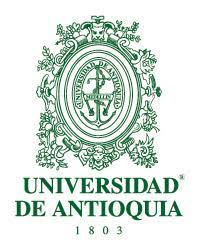


<h1> Modulation Recognition using Deep Learning models <h1>

**Tratamiento de Señales III**

**Integrantes**

- Carolina Jiménez Restrepo

- Mariana Noreña Vásquez

## Librerías

In [1]:
import os,random
import numpy as np
import pickle, sys
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.models as models

from tensorflow import keras
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *


%matplotlib inline

## Conjunto de datos



In [2]:
# Se descarga el conjunto de datos
!gdown '1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K'

Downloading...
From: https://drive.google.com/uc?id=1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K
To: /content/RML2016.10a_dict.pkl
100% 641M/641M [00:07<00:00, 87.8MB/s]


In [3]:
# Se almacenan los datos en una variable
with open("RML2016.10a_dict.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding="latin1")

In [4]:
# Se identifica cuántas modulaciones y relaciones SNR hay en el dataset
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

In [5]:
print('Total de modulaciones: ', len(mods))
print('Tipos de modulaciones en el dataset: {}'.format(mods))
print('Total de SNRs', len(snrs))
print('Valores SNRS presentes en el dataset: {}'.format(snrs))

Total de modulaciones:  11
Tipos de modulaciones en el dataset: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Total de SNRs 20
Valores SNRS presentes en el dataset: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [6]:
def reconstructSignal(s):
    I = s[0,:]   # I component
    Q = s[1,:]   # Q component
    n = len(I)   # number of samples
    f = 1e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

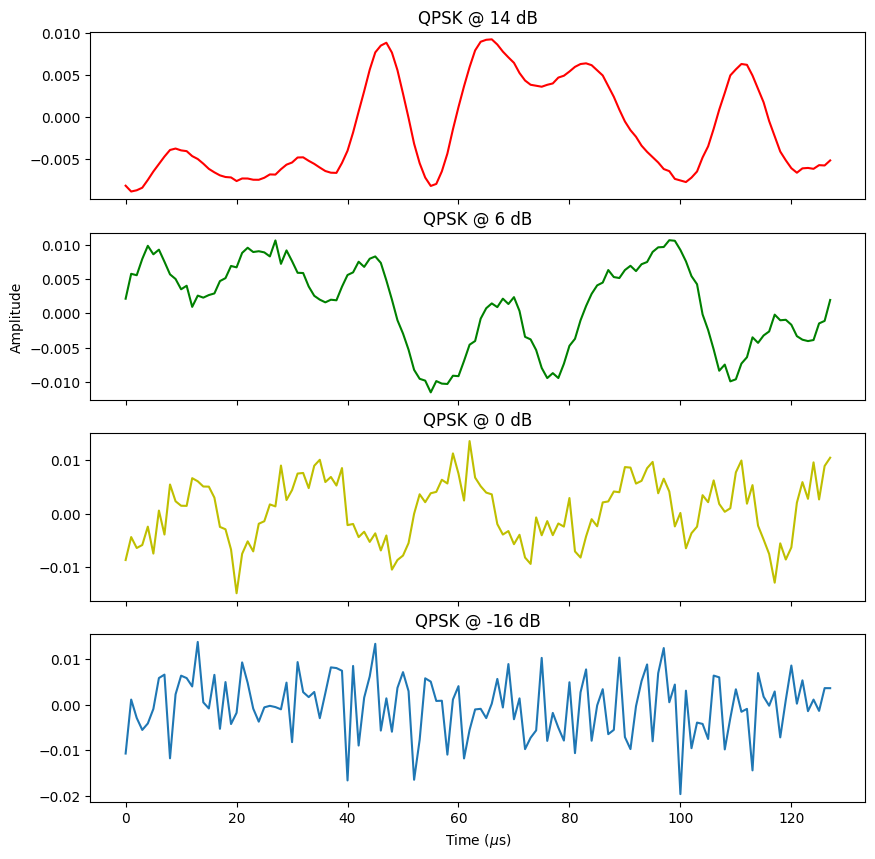

In [7]:
# Plot some of the data
nFigs = 4

plt.figure(figsize=(10, 10))

ax1 = plt.subplot(nFigs, 1, 1);
plt.plot(reconstructSignal(Xd['QPSK', 14][2,:,:]), color='r');
plt.title('QPSK @ 14 dB')

ax2 = plt.subplot(nFigs, 1, 2, sharex=ax1);
plt.plot(reconstructSignal(Xd['QPSK', 6][99,:,:]), color='g');
plt.title('QPSK @ 6 dB')

plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 1, 3, sharex=ax1)
plt.plot(reconstructSignal(Xd['QPSK', 0][456,:,:]), color='y');
plt.title('QPSK @ 0 dB')

ax4 = plt.subplot(nFigs, 1, 4, sharex=ax1)
plt.plot(reconstructSignal(Xd['QPSK', -16][32,:,:]));
plt.title('QPSK @ -16 dB')

# We only need to show the xticks on the bottom subplot
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlabel(r'Time ($\mu$s)');

Las muestras, modulaciones, SNRs y canales formarán una matriz cuyas dimensiones están definidas de la siguiente manera:

- El dataset contiene 11 modulaciones donde cada una cuenta con un total de 1000 muestras. Y, además, se tienen 20 relaciones señal a ruido.

  $11*1000*20=22000$

**Preguntarle al profe acerca de las dimensiones del dataset. El 128 a que hace referencia**

In [8]:
# Todos los datos que componen el dataset pasan a formar una matrix
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
X.shape

(220000, 2, 128)

In [9]:
# Se agrega ruido al dataset matricial, para que la clasificación tenga que elegir en caso de que no pueda clasificar bien los datos

numNoiseSamples = 20000 # Add 20,000 samples of just Gaussian noise
for i in range(numNoiseSamples):
    lbl.append(['Noise', snrs[i%len(snrs)]])

mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X = np.concatenate((X, X_noise))  # Add noise to the end of the data

In [10]:
# Se convierte a un array de binarios
lbl = np.array(lbl) # Convert from list to numpy array (for speed)

y_encoded = LabelBinarizer().fit_transform(lbl[:,0])

print(y_encoded.shape)

(240000, 12)


## Train Test Split

In [27]:
# Train 70%, test 30%
w, h = 2, 128
X_train, X_test, Y_train, Y_test = train_test_split(X, y_encoded, test_size=0.30, random_state=2016)
(X_train, X_valid) = X_train[8000:], X_train[:8000]
(Y_train, Y_valid) = Y_train[8000:], Y_train[:8000]

print('Training set: {}'.format(np.shape(X_train)))
print('Validation set: {}'.format(np.shape(X_valid)))
print('Test set: {}'.format(np.shape(X_test)))

Training set: (160000, 2, 128)
Validation set: (8000, 2, 128)
Test set: (72000, 2, 128)


In [41]:
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)

# Now get a list of random indicies to sample for the training set
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# Testing set is whatever indicies are left over
test_idx = list(set(range(0,n_examples))-set(train_idx))

# Now split up the data by the random indicies
X_train = X[train_idx]
X_test =  X[test_idx]
Y_train = y_encoded[train_idx]
Y_test = y_encoded[test_idx]

In [42]:
# Se tienen 12 clases, 11 modulación más el ruido que se agregó
in_shp = list(X_train.shape[1:])   # This is the input shape of 2 channels x 128 time samples
print(X_train.shape, in_shp)
classes = mods
print(classes)

(168000, 2, 128) [2, 128]
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM', 'Noise']


In [43]:
# Reshape de train, valid y test (-,2,128,1)
X_train = X_train.reshape(X_train.shape[0], w, h, 1)
X_valid = X_valid.reshape(X_valid.shape[0], w, h, 1)
X_test = X_test.reshape(X_test.shape[0], w, h, 1)

'''
y_train = tf.keras.utils.to_categorical(Y_train, 12)
y_valid = tf.keras.utils.to_categorical(Y_valid, 12)
y_test = tf.keras.utils.to_categorical(Y_test, 12)
'''

'\ny_train = tf.keras.utils.to_categorical(Y_train, 12)\ny_valid = tf.keras.utils.to_categorical(Y_valid, 12)\ny_test = tf.keras.utils.to_categorical(Y_test, 12)\n'

## NN Model

In [15]:
dr = 0.6 # dropout rate (%) = percentage of neurons to randomly lose each iteration
classes = 12
model = models.Sequential()

#Reshape
model.add(Reshape((w,h,1), input_shape=(w,h)))

# Must define the input shape in the first layer of the neural network
model.add(Convolution2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(w,h,1)))

model.add(Convolution2D(filters=32, kernel_size=2, padding='same', activation='relu'))

model.add(Convolution2D(filters=64, kernel_size=2, padding='same', activation='relu'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(classes, activation='softmax'))

# Take a look at the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 128, 16)        80        
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 128, 32)        2080      
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 128, 64)        8256      
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               8389120   
                                                                 
 dropout_3 (Dropout)         (None, 512)              

In [16]:
# Se compila el modelo creado

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

## Entrenamiento del modelo

In [17]:
# Set up some params
nb_epoch = 250     # number of epochs to train on
batch_size = 1024  # training batch size

In [44]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = './'
modelWeightsFile = filepath + 'PESOS_TSIII.wts.h5'  # Save the model weights to this file

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_valid, Y_valid),
    callbacks = [
        keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(modelWeightsFile)

Epoch 1/250

Epoch 1: val_loss improved from inf to 1.20126, saving model to ./PESOS_TSIII.wts.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


165/165 - 6s - loss: 1.2764 - accuracy: 0.5024 - val_loss: 1.2013 - val_accuracy: 0.5314 - 6s/epoch - 36ms/step
Epoch 2/250

Epoch 2: val_loss improved from 1.20126 to 1.19127, saving model to ./PESOS_TSIII.wts.h5
165/165 - 6s - loss: 1.2691 - accuracy: 0.5046 - val_loss: 1.1913 - val_accuracy: 0.5370 - 6s/epoch - 34ms/step
Epoch 3/250

Epoch 3: val_loss did not improve from 1.19127
165/165 - 5s - loss: 1.2608 - accuracy: 0.5062 - val_loss: 1.1934 - val_accuracy: 0.5339 - 5s/epoch - 32ms/step
Epoch 4/250

Epoch 4: val_loss improved from 1.19127 to 1.18524, saving model to ./PESOS_TSIII.wts.h5
165/165 - 6s - loss: 1.2569 - accuracy: 0.5084 - val_loss: 1.1852 - val_accuracy: 0.5376 - 6s/epoch - 34ms/step
Epoch 5/250

Epoch 5: val_loss improved from 1.18524 to 1.17856, saving model to ./PESOS_TSIII.wts.h5
165/165 - 5s - loss: 1.2527 - accuracy: 0.5100 - val_loss: 1.1786 - val_accuracy: 0.5360 - 5s/epoch - 33ms/step
Epoch 6/250

Epoch 6: val_loss improved from 1.17856 to 1.17273, saving mo

## Evaluación del modelo

In [45]:
y_predict = model.predict(X_test, batch_size=batch_size)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(y_predict, axis=1)))

'''
pred = []
for i in y_predict:
  pred.append(np.where(i < np.max(i), 0, 1))

pred = np.array(pred)
pred[:5]
'''

71/71 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.40      0.51      0.45      5957
           1       0.49      0.73      0.59      5852
           2       0.26      0.95      0.41      5932
           3       0.81      0.59      0.69      6051
           4       0.85      0.49      0.62      5963
           5       0.71      0.60      0.65      6022
           6       1.00      1.00      1.00      6125
           7       0.88      0.66      0.75      5991
           8       0.27      0.11      0.15      5906
           9       0.52      0.67      0.59      6029
          10       0.62      0.00      0.01      6072
          11       0.61      0.08      0.14      6100

    accuracy                           0.53     72000
   macro avg       0.62      0.53      0.50     72000
weighted avg       0.62      0.53      0.50     72000



'\npred = []\nfor i in y_predict:\n  pred.append(np.where(i < np.max(i), 0, 1))\n\npred = np.array(pred)\npred[:5]\n'

## Curva de pérdidas

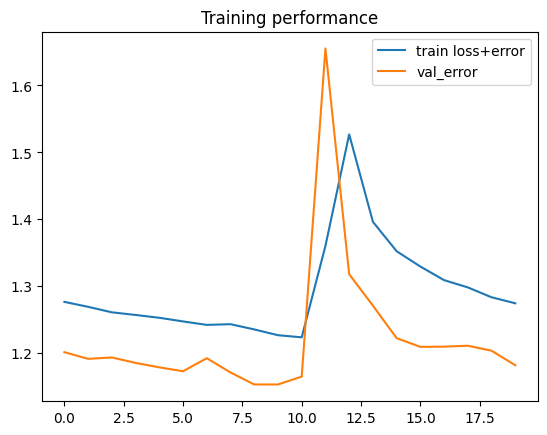

In [46]:
# Show loss curves
plt.figure();
plt.title('Training performance');
plt.plot(history.epoch, history.history['loss'], label='train loss+error');
plt.plot(history.epoch, history.history['val_loss'], label='val_error');
plt.legend();

## Confusion Matrix

In [47]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

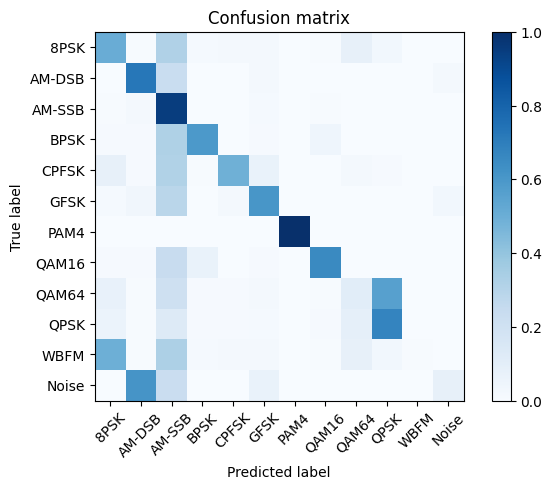

In [48]:
# Plot confusion matrix
classes = mods
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(y_predict[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

112/112 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -20: 0.1715563006426376
113/113 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -18: 0.1827748546109111
115/115 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -16: 0.18447663295982508
114/114 [==============================] - 1s 5ms/step
Overall Accuracy for SNR -14: 0.1997792494481236
115/115 [==============================] - 1s 5ms/step
Overall Accuracy for SNR -12: 0.23247535596933186
116/116 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -10: 0.3125339120998372
111/111 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -8: 0.4141928187729714
112/112 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -6: 0.5090959977609851
112/112 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -4: 0.6011722020653084
114/114 [==============================] - 0s 2ms/step
Overall Ac

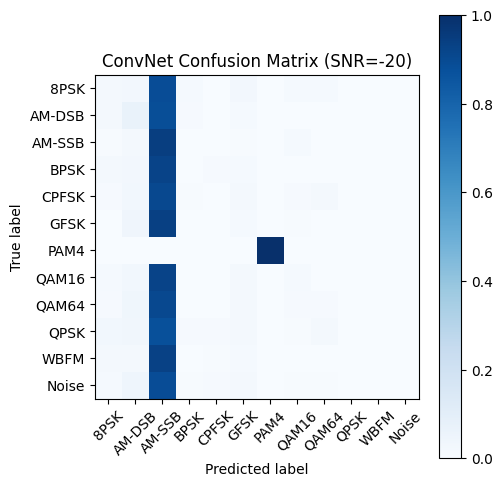

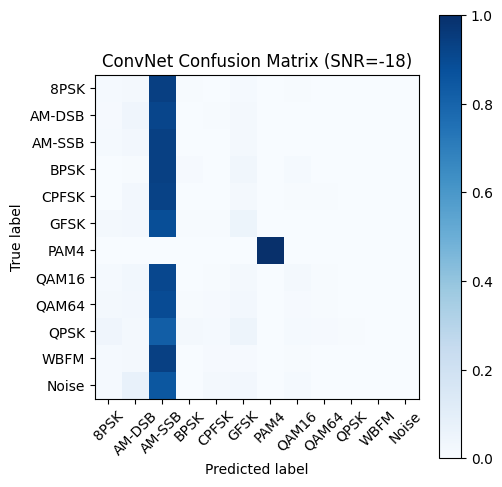

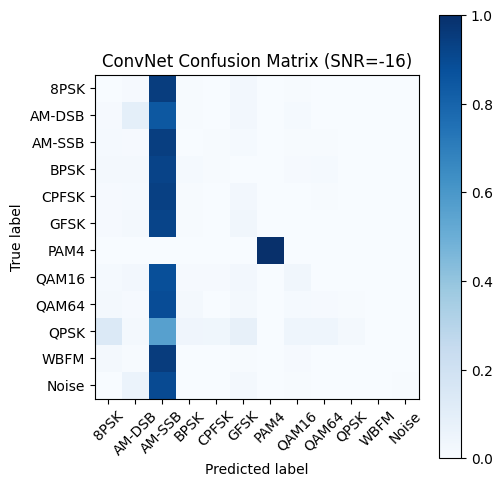

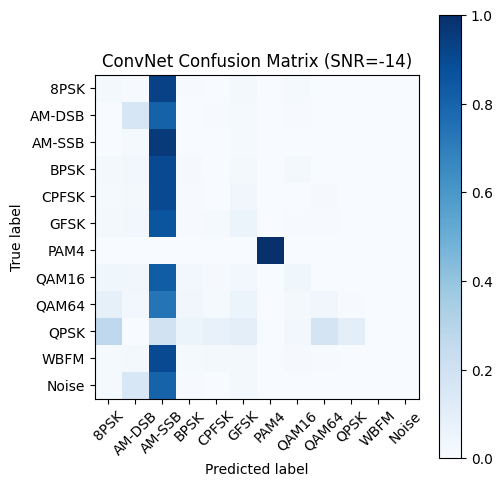

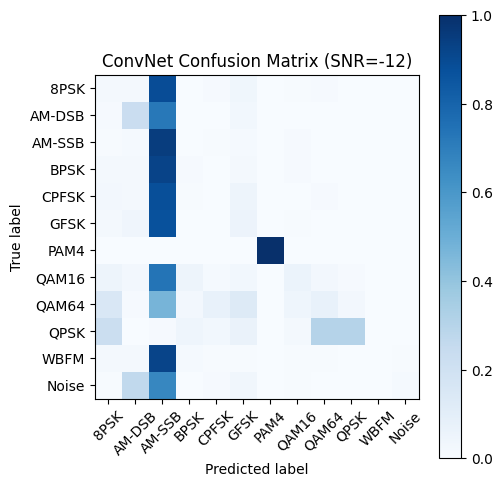

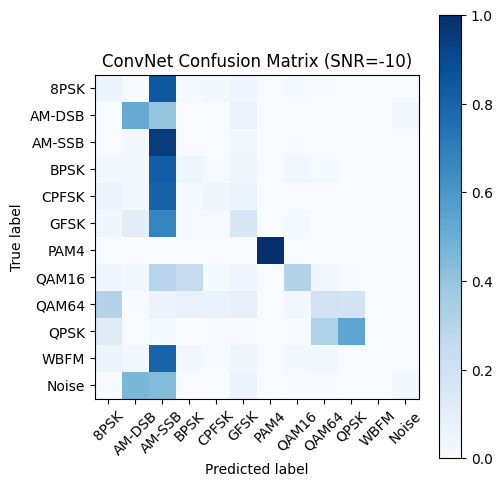

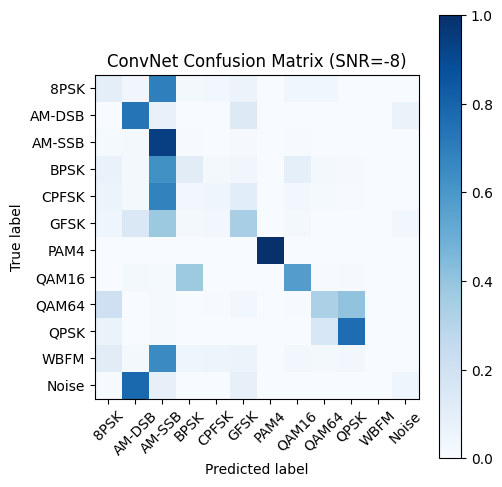

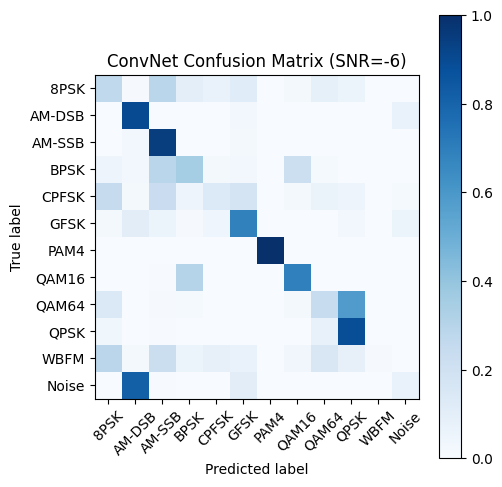

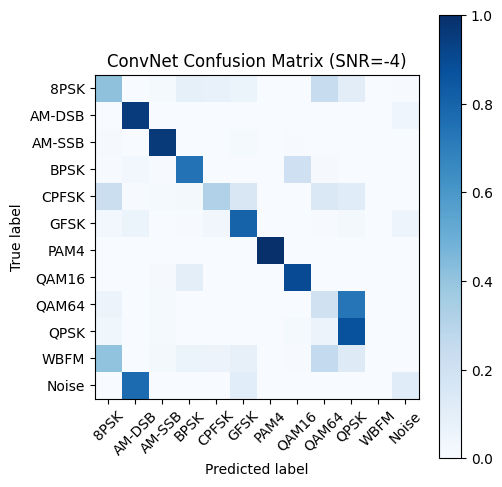

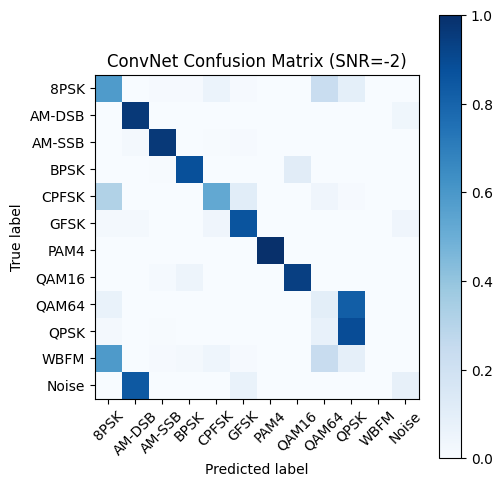

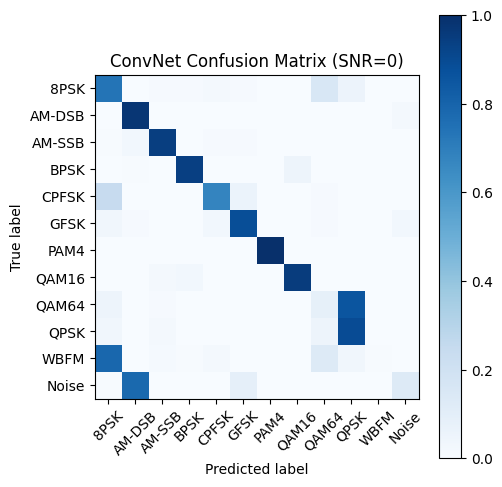

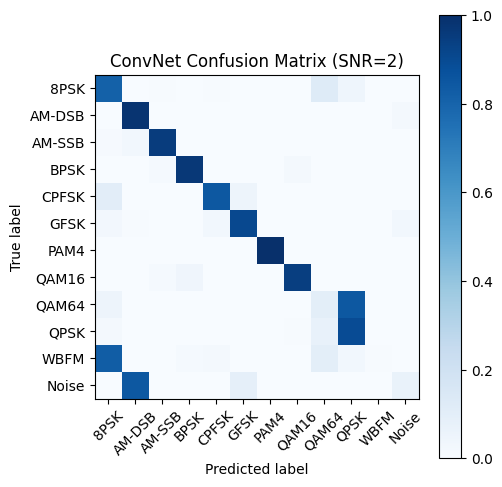

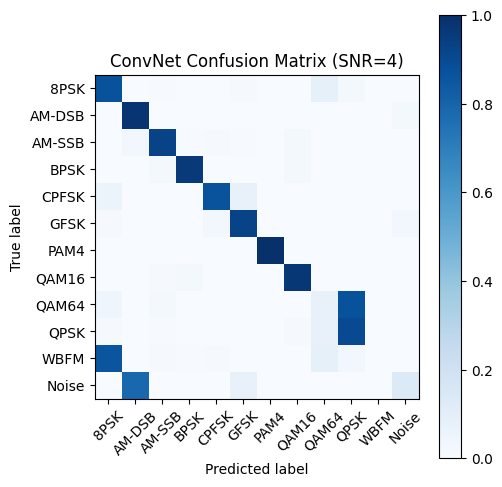

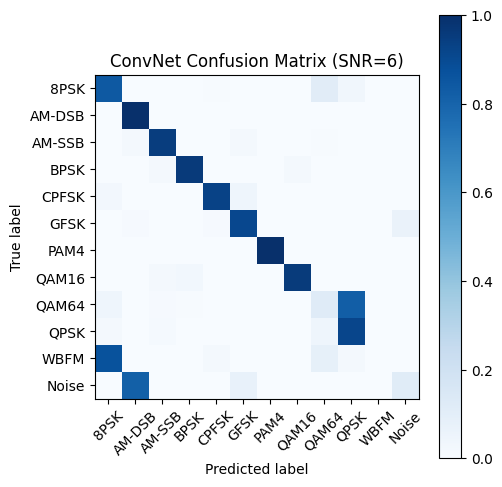

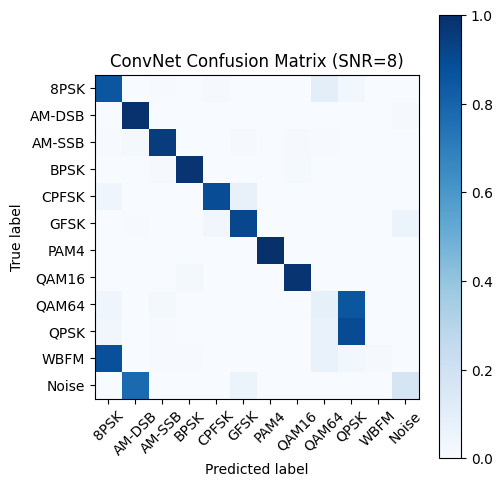

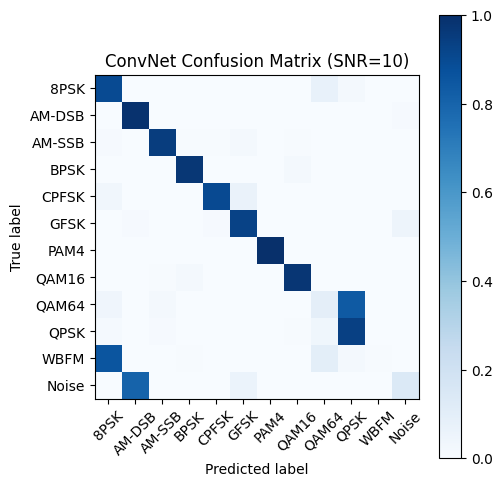

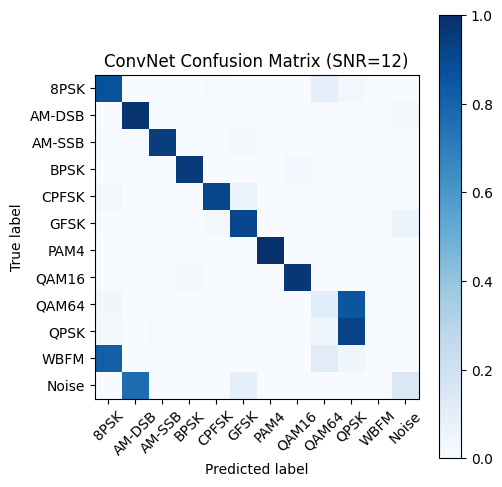

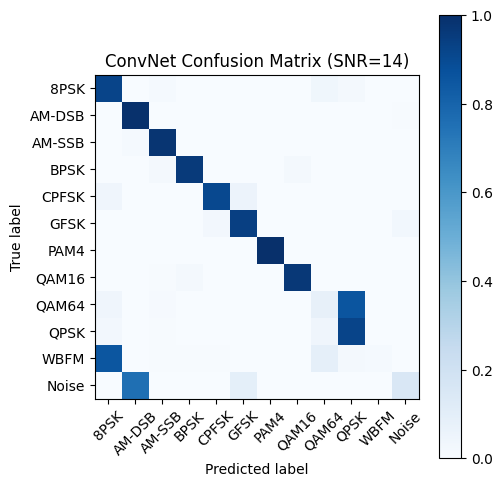

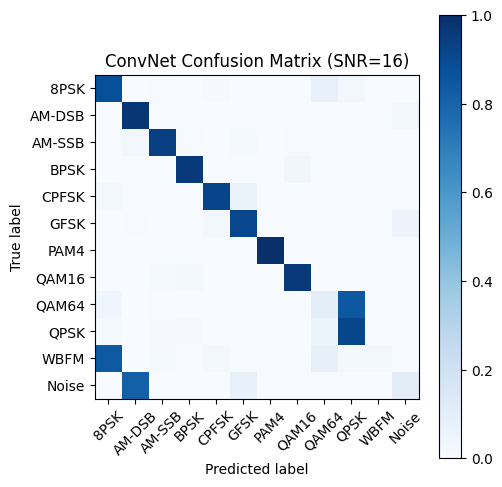

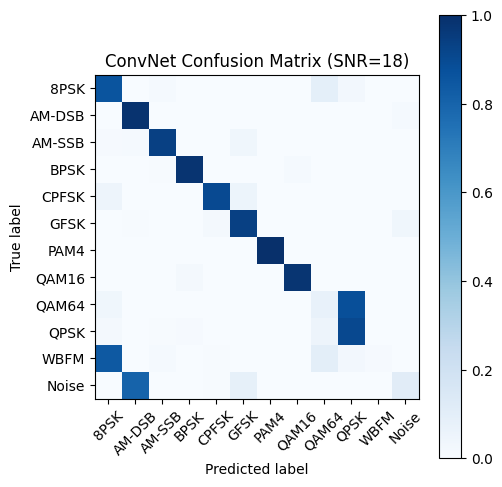

In [90]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: int(lbl[x][1]), test_idx)
    test_S = []
    for i in test_SNRs:
      test_S.append(i)
    test_S = np.array(test_S)
    test_X_i = X_test[np.where(test_S == snr)]
    test_Y_i = Y_test[np.where(test_S == snr)]

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy for SNR {}: {}".format(snr, cor / (cor+ncor)))
    acc[snr] = 1.0*cor/(cor+ncor)

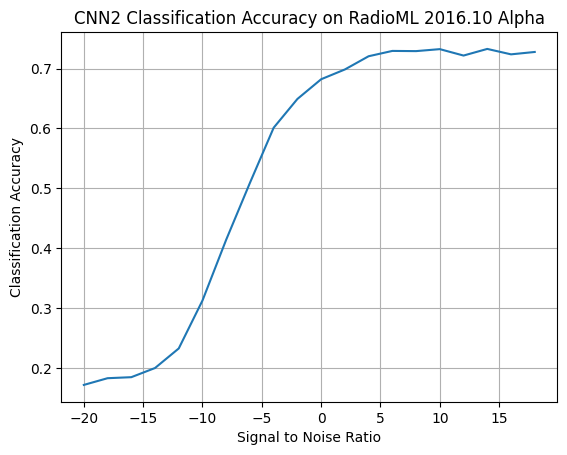

In [93]:
# Plot accuracy curve
a =  map(lambda x: acc[x], snrs)
aux = []
for i in a:
  aux.append(i)

plt.plot(snrs, aux);
plt.xlabel("Signal to Noise Ratio");
plt.ylabel("Classification Accuracy");
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha");
plt.grid()